In [22]:
import torch
import os
import torch.nn as nn

import torchvision
from torchvision import datasets

from models import VariationalAutoEncoderCelebA
from tqdm.auto import tqdm, trange
import numpy as np

import pandas as pd

from PIL import Image

from utils import output_to_pil

from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

1.7.0


In [2]:
def load_image(path):
    img = Image.open(path)
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor()
    ])
    return transform(img)


class Dataset:
    def __init__(self, path_to_jpg):
        self.path = path_to_jpg
        self.filenames = os.listdir(path_to_jpg)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        return load_image(self.path + '/' + self.filenames[item])

In [3]:
data = Dataset("../data/celeba/img_align_celeba/img_align_celeba")
train, valid = torch.utils.data.random_split(data, [int(0.8*len(data)), len(data)-int(0.8*len(data))])

In [4]:
model = VariationalAutoEncoderCelebA(3, 200, 3).to("cuda")
reconstruction_loss_fn = nn.MSELoss().to("cuda")
kl_loss_fn = lambda mu, log_var: -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False)
kl_factor = 1e-5

In [5]:
for epoch in range(10):

    train_loss = 0
    valid_loss = 0

    model.train()
    for images in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        mu, log_var, output = model(images.to("cuda"))
        reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
        kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
        loss = reconstruction_loss + kl_factor * kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(dataloader)

    model.eval()
    with torch.no_grad():
        for images in tqdm(valid_loader, leave=False):
            mu, log_var, output = model(images.to("cuda"))
            reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
            kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
            loss = reconstruction_loss + kl_factor * kl_loss
            valid_loss += loss.item() / len(valid_loader)

    print(f"Epoch {epoch+1}: train_loss {train_loss}, valid_loss {valid_loss}")

Epoch 1: train_loss 0.02304630192090465, valid_loss 0.014289548198670949
Epoch 2: train_loss 0.016494126563113984, valid_loss 0.012444404806980282
Epoch 3: train_loss 0.015153632785753528, valid_loss 0.012313476782443865
Epoch 4: train_loss 0.014489543198921389, valid_loss 0.011697740191132889
Epoch 5: train_loss 0.014058016928837727, valid_loss 0.011864764706876474
Epoch 6: train_loss 0.013738320082212733, valid_loss 0.011317463488851726
Epoch 7: train_loss 0.013531049172350748, valid_loss 0.011501423781703159
Epoch 8: train_loss 0.013324535054477402, valid_loss 0.011788612286728475
Epoch 9: train_loss 0.013180491240531436, valid_loss 0.011798381310327264
Epoch 10: train_loss 0.013027425645413884, valid_loss 0.011768534718261083


In [5]:
model.load_state_dict(torch.load("models/vae_celeba.pt"))

<All keys matched successfully>

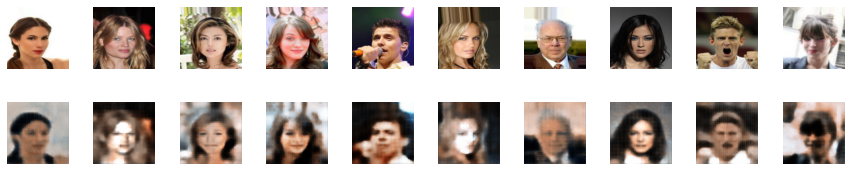

In [16]:
n_to_show = 10

data_iterator = iter(valid_loader)
example_images = [next(data_iterator) for _ in range(10)]
reconst_images = [model(image.cuda())[2].cpu().detach() for image in example_images]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img.permute(1,2,0))

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img.permute(1,2,0))

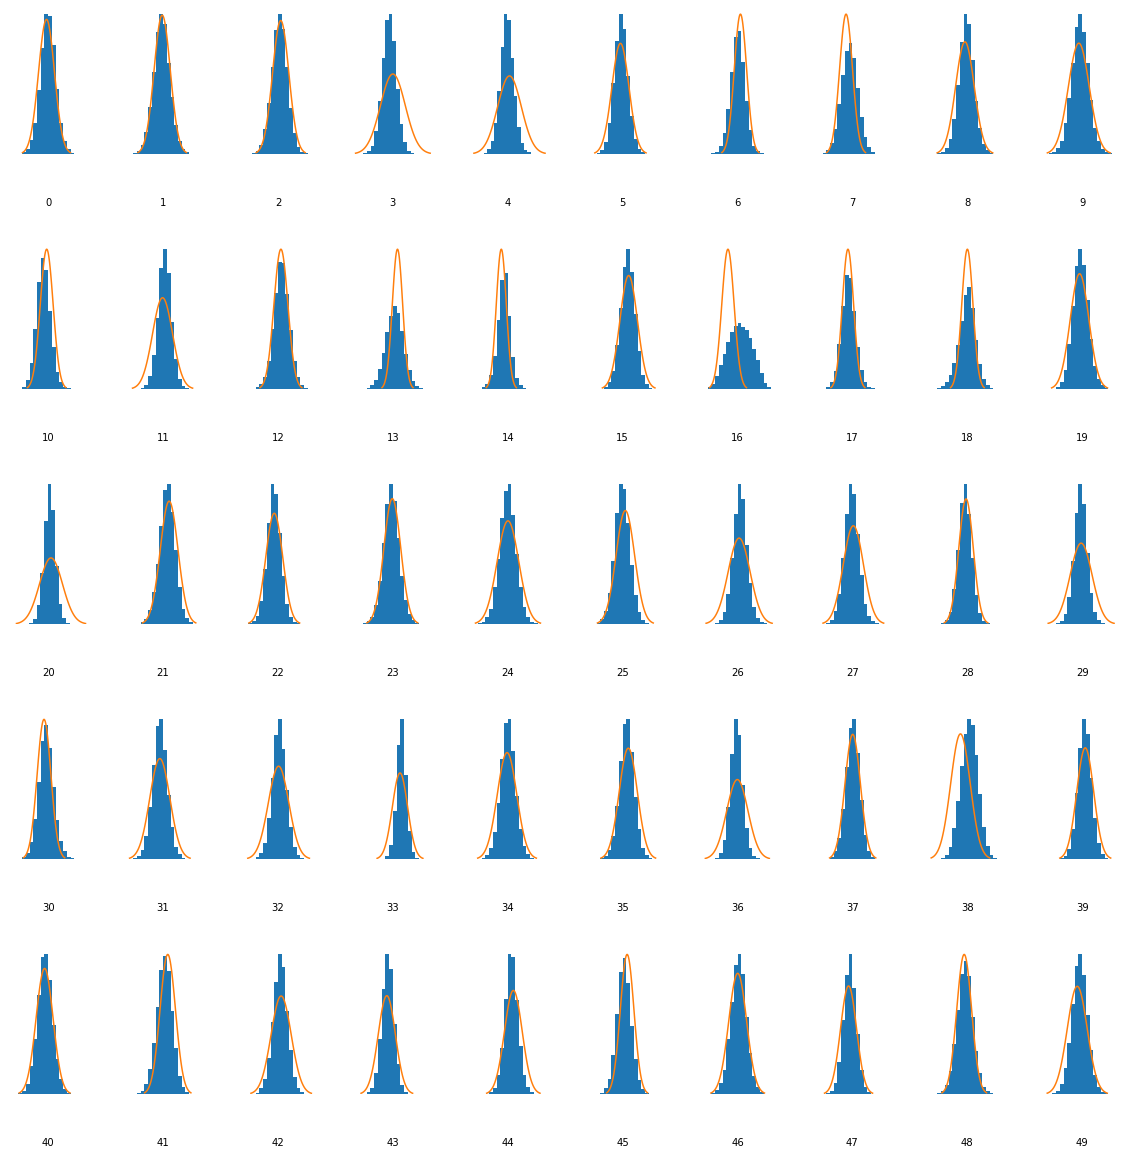

In [20]:
model.eval()
mus = []

with torch.no_grad():
    for images in tqdm(valid_loader, leave=False):
        mu, _, _ = model(images.to("cuda"))
        mus.append(mu.cpu().squeeze().detach().numpy())

mus = np.stack(mus)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(mus[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

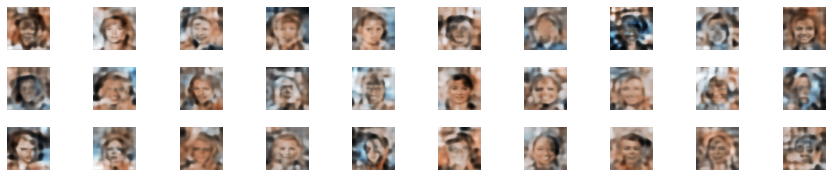

In [23]:
n_to_show = 30

generated_images = [model.decoder(torch.randn(1, 200).cuda()).cpu().detach() for _ in range(n_to_show)]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in trange(n_to_show):
    img = generated_images[i].squeeze()
    sub = fig.add_subplot(3, 10, i+1)
    sub.axis('off')
    sub.imshow(img.permute(1,2,0))
